In [ ]:
from tensorflow import keras

from tensorflow.keras import models, layers
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 

In [ ]:
# Preparing the dataset and creating the features and target arrays


pd.set_option('mode.chained_assignment', None)

n_sims = 10000
n_list = [i for i in range(n_sims)]


start = 0
end = 10000

x = []
y =[]

for i in n_list[start:end]:
	
	data = np.load(f'input/data_{i+1}.npy')
	x.append(data[:, :2])
	y.append(data[:, 2:][0][0])
	print(f'Status: {((i+1)/end * 100):.2f} %', end='\r')


x = np.array(x)
# x[:,:,0] /= x[:,:,0].max()


y = np.array(y)

norm = y.max()


y /= norm


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [68]:
# defining the model

model = models.Sequential()

model.add(layers.Flatten())


model.add(layers.Dense(16, activation='relu'))
# model.add(layers.Dropout(.3))
model.add(layers.Dense(16, activation='relu'))

model.add(layers.Dense(1))

model.compile(loss=keras.losses.MeanSquaredError(), optimizer='nadam', metrics=keras.metrics.MeanAbsoluteError())


history = model.fit(x_train, y_train, validation_split=.1, epochs=25, batch_size=8, verbose=1, callbacks=[early_stopping])

Epoch 1/25
844/844 [==============================] - 5s 5ms/step - loss: 41.0390 - mean_absolute_error: 4.3664 - val_loss: 5.2745 - val_mean_absolute_error: 2.2254
Epoch 2/25
844/844 [==============================] - 7s 8ms/step - loss: 11.2138 - mean_absolute_error: 2.2476 - val_loss: 4.7450 - val_mean_absolute_error: 2.1279
Epoch 3/25
844/844 [==============================] - 6s 7ms/step - loss: 6.2545 - mean_absolute_error: 1.6393 - val_loss: 3.0074 - val_mean_absolute_error: 1.6876
Epoch 4/25
844/844 [==============================] - 5s 6ms/step - loss: 3.7158 - mean_absolute_error: 1.5661 - val_loss: 0.0944 - val_mean_absolute_error: 0.2625
Epoch 5/25
844/844 [==============================] - 4s 5ms/step - loss: 1.7448 - mean_absolute_error: 0.9964 - val_loss: 0.7674 - val_mean_absolute_error: 0.8433
Epoch 6/25
844/844 [==============================] - 4s 5ms/step - loss: 1.1873 - mean_absolute_error: 0.7727 - val_loss: 0.3240 - val_mean_absolute_error: 0.5376
Epoch 7/25
844

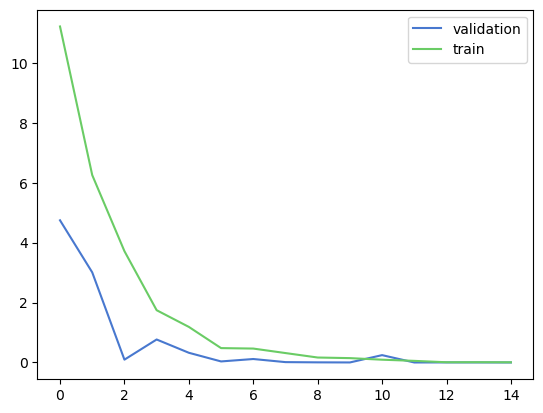

In [69]:
plt.plot(history.history['val_loss'][1:], label='validation')
plt.plot(history.history['loss'][1:], label='train')

plt.legend()
plt.show()

In [70]:
y_pred = model.predict(x_test)


r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)



79/79 [==============================] - 0s 1ms/step


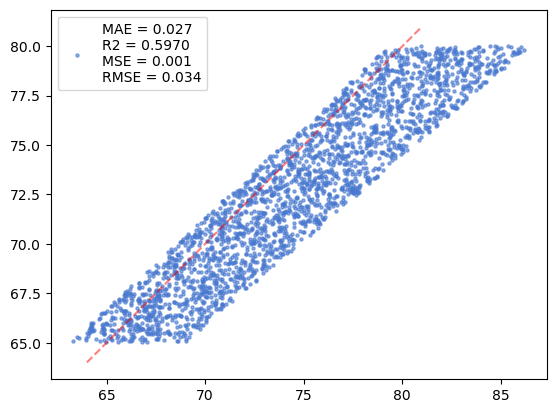

In [71]:
plt.style.use('seaborn-v0_8-muted')

linha = np.linspace(64, 81)
# linha = np.linspace(.31, .315, 2500)


plt.scatter(y_pred*norm, y_test*norm, s=5, alpha=.6, label=f'MAE = {mae:.3f}\nR2 = {r2:.4f}\nMSE = {mse:.3f}\nRMSE = {rmse:.3f}')
plt.plot(linha, linha, alpha=.5, c='red', ls='--')

plt.legend()
plt.savefig("imagens/metrics_h0_dense")
plt.show()

In [72]:
# forecasting "real" H(0)

real = np.load('input/data_real80.npy')
real = real[real[:, 0].argsort()]

real = real.reshape(-1,80,2)

In [73]:

final_real = model.predict(real, verbose=0)

In [74]:
final_real*norm

array([[68.75509]], dtype=float32)

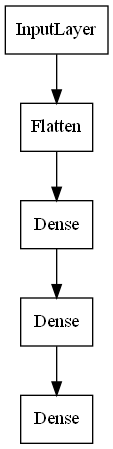

In [75]:
keras.utils.plot_model(model, to_file='imagens/model_dense.png', show_shapes=False, show_layer_names=False)
